# PARTE I: ANÁLISIS DE CARTERA DE ACCIONES
---
Construir y analizar una cartera de 5 acciones que incluya tu empresa asignada más 4 empresas comparables del mismo sector o mercado relevante.

---
##1. Construcción del Dataset

* Obtener datos históricos diarios de los últimos 5 años
* Justificar la selección de las 4 empresas comparables basándose en:
  *   Sector económico
  *   Capitalización de mercado similar
  *   Mercado de cotización relevante
* Documentar fuentes de datos y metodología de limpieza
* Incluir índice de referencia (MERVAL, S&P500, etc.)

---

### Obtencion del dataset

In [1]:
# Instalar yfinance
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import numpy as np

# Definir tickers y fechas
tickers_empresas = ["LOMA", "CRH", "CX", "VMC", "PAM", "SPY"]
ticker_merval = "^MERV"
tickers_galicia = ["GGAL.BA", "GGAL"]
start_date = "2020-07-01"

print("Descargando datos financieros...")

# 1. Descargar empresas + SPY
print("1. Descargando empresas + SPY...")
data_empresas = yf.download(
    tickers_empresas,
    start=start_date,
    progress=False,
    auto_adjust=False
)

# Extraer solo precios ajustados
if len(tickers_empresas) > 1:
    data_empresas_adj = data_empresas["Adj Close"]
else:
    data_empresas_adj = data_empresas[["Adj Close"]].rename(columns={"Adj Close": tickers_empresas[0]})

# 2. Descargar MERVAL
print("2. Descargando MERVAL...")
raw_merval = yf.download(
    ticker_merval,
    start=start_date,
    progress=False,
    auto_adjust=False
)

# Extraer MERVAL ajustado de forma más robusta
if isinstance(raw_merval, pd.DataFrame):
    if "Adj Close" in raw_merval.columns:
        merval_pesos = raw_merval["Adj Close"]
    elif raw_merval.columns.nlevels == 2:
        # Si hay multiindex, buscar la columna correcta
        adj_close_cols = [col for col in raw_merval.columns if col[1] == "Adj Close"]
        if adj_close_cols:
            merval_pesos = raw_merval[adj_close_cols[0]]
        else:
            merval_pesos = raw_merval.iloc[:, 0]
    else:
        merval_pesos = raw_merval.iloc[:, 0]
elif isinstance(raw_merval, pd.Series):
    merval_pesos = raw_merval
else:
    raise Exception("Error al descargar MERVAL.")

# Asegurarse de que merval_pesos sea una Serie
if isinstance(merval_pesos, pd.DataFrame):
    merval_pesos = merval_pesos.iloc[:, 0]

# 3. Descargar GGAL (ars y usd)
print("3. Descargando GGAL...")
raw_ggal = yf.download(
    tickers_galicia,
    start=start_date,
    progress=False,
    auto_adjust=False
)

# Extraer precios ajustados de GGAL
if len(tickers_galicia) > 1:
    data_ggal = raw_ggal["Adj Close"]
else:
    data_ggal = raw_ggal[["Adj Close"]].rename(columns={"Adj Close": tickers_galicia[0]})

# Verificar que ambas columnas existen
if "GGAL.BA" not in data_ggal.columns or "GGAL" not in data_ggal.columns:
    print("Error: No se pudieron descargar ambas versiones de GGAL")
    print("Columnas disponibles:", data_ggal.columns.tolist())
    # Usar un valor fijo como fallback o terminar
    raise Exception("No se pudieron descargar los datos de GGAL necesarios para calcular el CCL")

# Calcular dólar CCL (GGAL.BA * 10 / GGAL)
# Nota: 10 acciones locales GGAL.BA = 1 ADR GGAL
print("4. Calculando dólar CCL...")
dolar_ccl = (data_ggal["GGAL.BA"] * 10) / data_ggal["GGAL"]

# Eliminar valores infinitos o NaN del dólar CCL
dolar_ccl = dolar_ccl.replace([np.inf, -np.inf], np.nan)

# 5. Crear DataFrame final
print("5. Consolidando datos...")
df = data_empresas_adj.copy()

# Convertir MERVAL a USD usando CCL - asegurándonos que sea una Serie
merval_usd = merval_pesos / dolar_ccl
merval_usd = merval_usd.dropna()  # Eliminar NaN

# Agregar MERVAL en USD al DataFrame principal
# Usar concat para evitar problemas de asignación
df_merval = pd.DataFrame({"Merval USDCCL": merval_usd})
df = pd.concat([df, df_merval], axis=1)

# Ordenar por fecha y rellenar valores faltantes
df = df.sort_index()
df = df.fillna(method='ffill')  # Forward fill

# Resetear el índice (poner fechas como columna)
df = df.reset_index()
if 'Date' in df.columns:
    df = df.rename(columns={"Date": "FECHA"})
elif 'Datetime' in df.columns:
    df = df.rename(columns={"Datetime": "FECHA"})

# Verificar que todas las columnas existen antes de seleccionar
cols_disponibles = df.columns.tolist()
cols_deseadas = ["FECHA"] + tickers_empresas + ["Merval USDCCL"]
cols_finales = [col for col in cols_deseadas if col in cols_disponibles]

if "Merval USDCCL" not in cols_finales:
    print("Advertencia: No se pudo crear la columna 'Merval USDCCL'")
    print("Columnas disponibles:", cols_disponibles)

# Crear DataFrame final con las columnas que existen
df_final = df[cols_finales].copy()

# Guardar a CSV
csv_file = "Precios.csv"
df_final.to_csv(csv_file, index=False)

print(f"\n✅ Archivo guardado como: {csv_file}")
print(f"📊 Datos desde: {start_date}")
print(f"📈 Empresas incluidas: {', '.join(tickers_empresas)}")
print(f"🇦🇷 MERVAL convertido a USD usando CCL")

# Mostrar las primeras filas para control
print("\n" + "="*50)
print("PRIMERAS 10 FILAS:")
print("="*50)
print(df_final.head(10))

print(f"\n📋 Columnas en el archivo: {list(df_final.columns)}")
print(f"📏 Shape del archivo final: {df_final.shape}")
print(f"📅 Rango de fechas: {df_final['FECHA'].min()} a {df_final['FECHA'].max()}")

# Mostrar estadísticas del dólar CCL para verificar
if "Merval USDCCL" in df_final.columns:
    print(f"\n💱 Dólar CCL promedio en el período: {dolar_ccl.mean():.2f}")
    print(f"💱 Dólar CCL último valor: {dolar_ccl.iloc[-1]:.2f}")

Descargando datos financieros...
1. Descargando empresas + SPY...
2. Descargando MERVAL...
3. Descargando GGAL...
4. Calculando dólar CCL...
5. Consolidando datos...

✅ Archivo guardado como: Precios.csv
📊 Datos desde: 2020-07-01
📈 Empresas incluidas: LOMA, CRH, CX, VMC, PAM, SPY
🇦🇷 MERVAL convertido a USD usando CCL

PRIMERAS 10 FILAS:
       FECHA      LOMA        CRH        CX         VMC    PAM         SPY  \
0 2020-07-01  2.813911  29.986683  2.703461  111.011078  10.78  289.130829   
1 2020-07-02  2.715751  30.701271  2.772276  115.663658  10.39  290.722992   
2 2020-07-06  3.056038  31.192003  2.821430  118.449471  11.65  295.210999   
3 2020-07-07  2.918615  31.114519  2.732953  117.434723  11.22  292.166199   
4 2020-07-08  2.898983  30.847633  2.703461  114.036217  11.46  294.400879   
5 2020-07-09  2.781191  30.477428  2.605153  112.102417  10.98  292.724915   
6 2020-07-10  2.820455  31.441683  2.595323  113.720314  11.36  295.713806   
7 2020-07-13  2.918615  30.813200  2.

/tmp/ipython-input-1751847483.py:107: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward fill


###Pregunta Crítica
¿Qué criterios utilizaste para seleccionar empresas comparables y por qué estos criterios son relevantes para un inversor argentino?

Justificación de la Selección de Comparables:

Usé Finviz para filtrar por el sector de materiales básicos y materiales de construcción, que es donde se encuentra Loma Negra. A partir de eso, elegí como comparables a CRH plc, Cemex y Vulcan Materials, ya que son empresas líderes a nivel global en el sector cementero y de materiales de construcción, con operaciones internacionales y cotización en mercados líquidos como la NYSE. Si bien son compañías más grandes en términos de capitalización, sirven como buenos benchmarks del sector.

En el caso del mercado argentino, no encontré otras cementeras del nivel de Loma Negra que coticen en bolsa. Por eso sumé a Pampa Energía, una de las empresas más grandes y con mayor liquidez del país. Esto me permite tener en cuenta el riesgo país y la volatilidad del mercado local, para poder comparar con empresas del exterior en un mismo análisis.


| Empresa	| Ticker | Sector	| Región | ¿Por qué es comparable? |
|---------|--------|--------|--------|-------------------------|
| Loma Negra | LOMA	| cemento y materiales de construcción | Argentina | Principal cementera argentina cotizada, referente local en el sector. |
|CRH plc | CRH | Materiales de construcción | Irlanda/Global | Líder global en materiales de construcción, benchmark internacional.|
| Cemex	| CX | Cemento y materiales de construcción	| México/Global	| Cementera global con ADR en NYSE, operaciones internacionales. |
|Vulcan Materials	| VMC	| Agregados (piedra, arena, grava) | EE.UU./Global| Líder en agregados, clave en construcción, similar industria. |
|Pampa Energía | PAM | Energía (eléctrica, gas)	| Argentina	| Añadida para capturar riesgo país, una de las más líquidas del mercado local.|

---
##2. Análisis Descriptivo Avanzado

* Gráficos de precios normalizados (base 100)
* Identificar y explicar 3 eventos (macroeconómicos/corporativos) que impactaron significativamente en los precios.
* Análisis de estacionalidad por trimestres.
* Cálculo de métricas de riesgo:
  * VaR 95%
  * CVaR (Expected Shortfall)
  * Drawdown máximo
* Test de normalidad (Jarque-Bera) y análisis de colas

---

###Gráficos de precios normalizados (base 100)

1. Generando gráficos de precios normalizados (base 100)...


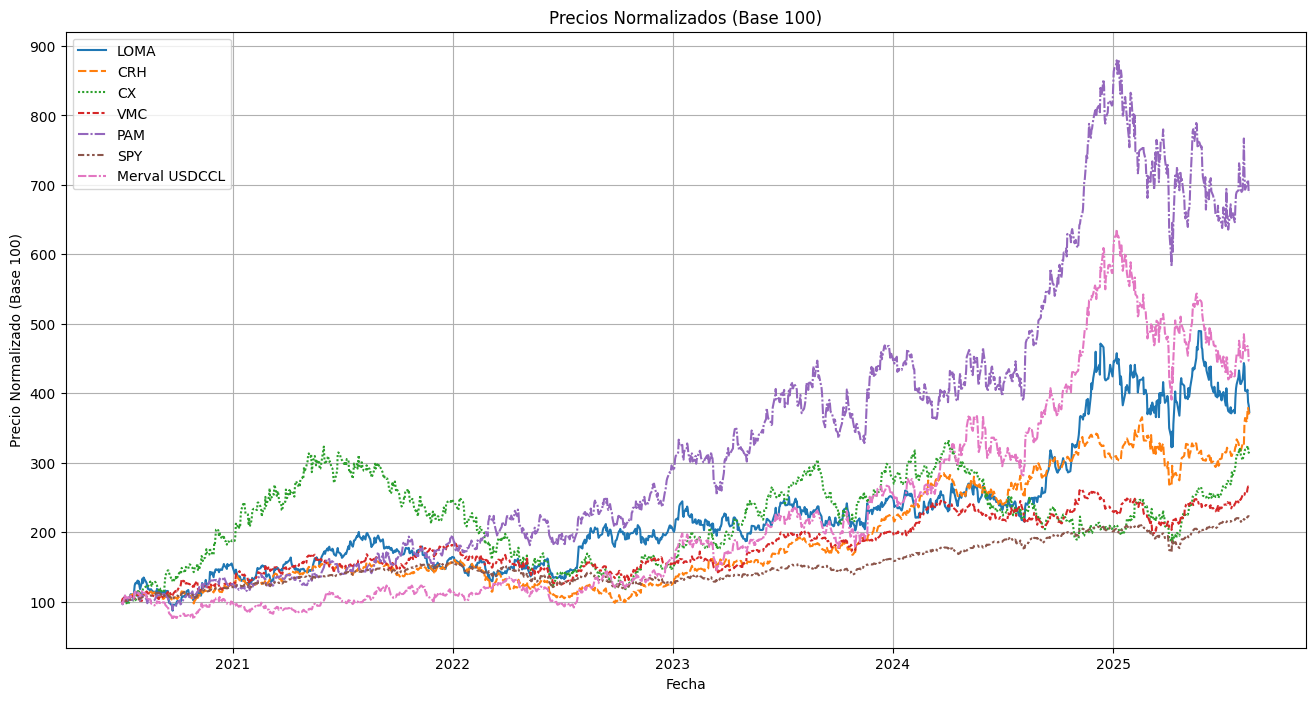

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import jarque_bera
import statsmodels.api as sm

# Set 'FECHA' as index
df_analysis = df_final.set_index('FECHA').copy()

# 1. Gráficos de precios normalizados (base 100)
print("1. Generando gráficos de precios normalizados (base 100)...")
df_normalized = df_analysis / df_analysis.iloc[0] * 100

plt.figure(figsize=(16, 8))
sns.lineplot(data=df_normalized)
plt.title('Precios Normalizados (Base 100)')
plt.xlabel('Fecha')
plt.ylabel('Precio Normalizado (Base 100)')
plt.grid(True)
plt.show()

###Identificar y explicar 3 eventos

| Evento                                | Fecha principal | Afectados principales             | Breve descripción                                                                 | Impacto resumido                                                                                     |
| ------------------------------------- | --------------- | ----------------------------------| --------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------- |
| Pandemia COVID-19 y crash global      | Marzo 2020      | Todas las acciones e índices      | Caída abrupta global por cuarentenas y freno económico.                           | Caídas superiores al 30% en semanas; fuerte aumento de la volatilidad y posterior rebote parcial.    |
| Rally pospandemia + inflación global  | 2021-2022       | CRH, CX, VMC, S\&P500 (+ globales)| Rebote de demanda, suba de precios y luego corrección por tasas altas e inflación | Fuertes subas en 2021, máximos históricos, luego corrección en 2022; oportunidad para trading activo.|
| Crisis argentina 2022/23 (devaluación)| 2022-2023       | LOMA, PAMP, MERVAL                | Inflación, devaluaciones, controles cambiarios y crisis política impacta Argentina| Altísima volatilidad y caída de precios en dólares; aumento del riesgo país y correlación local.     |



###Análisis de estacionalidad por trimestres

\Análisis de estacionalidad por trimestres...


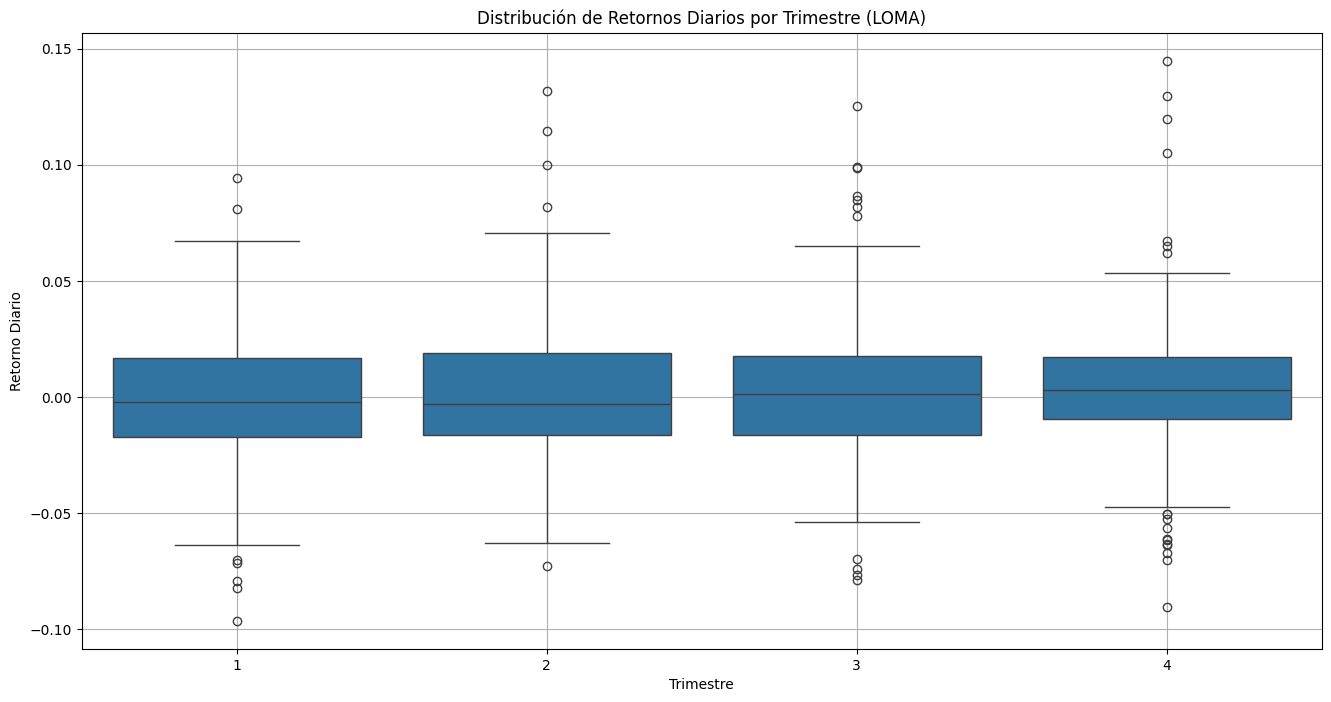

In [3]:
print("\Análisis de estacionalidad por trimestres...")
# Calcular retornos diarios
returns = df_analysis.pct_change().dropna()

# Añadir información del trimestre
returns['Quarter'] = returns.index.quarter

plt.figure(figsize=(16, 8))
sns.boxplot(x='Quarter', y='LOMA', data=returns) # Ejemplo para LOMA, se puede hacer para otros
plt.title('Distribución de Retornos Diarios por Trimestre (LOMA)')
plt.xlabel('Trimestre')
plt.ylabel('Retorno Diario')
plt.grid(True)
plt.show()

###Cálculo de métricas de riesgo

In [4]:
# 4. Cálculo de métricas de riesgo
print("\n4. Cálculo de métricas de riesgo...")

# Asegurarse de que df_analysis esté disponible y tenga los datos correctos
if 'df_final' not in locals():
    print("Error: DataFrame df_final no encontrado. Por favor, ejecute las celdas anteriores para crearlo.")
else:
    # Establecer 'FECHA' como índice
    df_analysis = df_final.set_index('FECHA').copy()

    # Definir los activos para el cálculo de métricas de riesgo
    assets = ['LOMA', 'CRH', 'CX', 'VMC', 'PAM'] # Las 5 empresas

    # Calcular retornos diarios y seleccionar solo las columnas de activos
    returns = df_analysis[assets].pct_change().dropna()

    # Manejar posibles etiquetas de índice duplicadas eliminando duplicados basados en el índice
    returns = returns[~returns.index.duplicated(keep='first')]


    # Calcular el Valor en Riesgo (VaR 95%) y el Valor en Riesgo Condicional (CVaR)
    confidence_level = 0.95
    alpha = 1 - confidence_level

    # Asumiendo retornos diarios y queriendo VaR/CVaR diario
    VaR = returns.quantile(alpha)
    CVaR = returns[returns <= VaR].mean()

    # Calcular el Drawdown Máximo
    def calculate_max_drawdown(prices):
        cumulative_returns = (1 + prices.pct_change().dropna()).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()
        return max_drawdown

    # Asegurarse de que returns contenga las columnas de los activos
    max_drawdowns = df_analysis[assets].apply(calculate_max_drawdown)


    # Mostrar las métricas de riesgo en una tabla
    print("\nTabla de Métricas de Riesgo:")

    # Combinar las métricas en un solo DataFrame para mostrar en tabla
    risk_metrics_df = pd.DataFrame({
        'VaR 95% Diario': VaR,
        'CVaR Diario': CVaR,
        'Maximum Drawdown': max_drawdowns
    })

    # Formatear para mejor lectura (opcional)
    risk_metrics_df = risk_metrics_df.map(lambda x: f"{x:.4f}")

    # Mostrar el DataFrame transpuesto
    display(risk_metrics_df.T)


4. Cálculo de métricas de riesgo...

Tabla de Métricas de Riesgo:


,LOMA,CRH,CX,VMC,PAM
VaR 95% Diario,-0.0428,-0.0300,-0.0418,-0.0274,-0.0431
CVaR Diario,-0.0560,-0.0396,-0.0547,-0.0368,-0.0555
Maximum Drawdown,-0.3542,-0.3866,-0.6400,-0.3250,-0.3376


###Test de normalidad (Jarque-Bera) y análisis de colas


Test de normalidad (Jarque-Bera) y análisis de colas...

Resultados del Test de Jarque-Bera:


,Jarque-Bera Statistic,p-value
LOMA,297.5636,0.0000
CRH,396.2579,0.0000
CX,150.7005,0.0000
VMC,282.0763,0.0000
PAM,260.0583,0.0000



Análisis de Colas (Skewness y Kurtosis):


,Skewness,Kurtosis
LOMA,0.4947,2.1513
CRH,0.3602,2.6363
CX,0.3331,1.5493
VMC,0.1042,2.2976
PAM,0.4787,1.9961



Gráfico de distribución de retornos (ejemplo para LOMA):


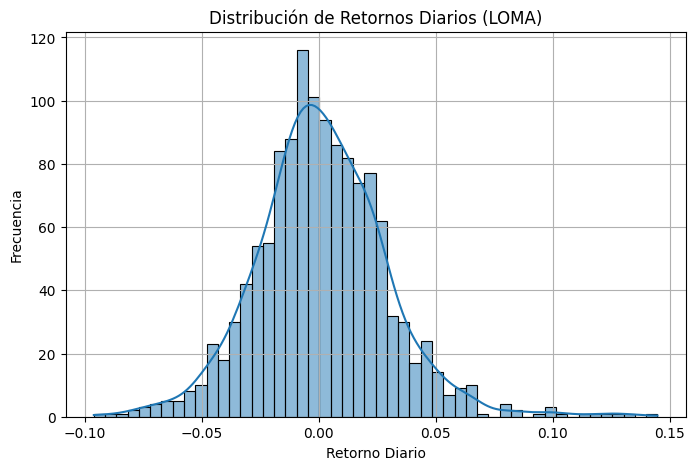

In [5]:
print("\nTest de normalidad (Jarque-Bera) y análisis de colas...")

# Realizar test de Jarque-Bera y almacenar resultados en un diccionario
jb_results = {}
print("\nResultados del Test de Jarque-Bera:")
# Excluir 'Quarter' de los retornos antes del test
returns_for_jb = returns.drop(columns=['Quarter']) if 'Quarter' in returns.columns else returns
for col in returns_for_jb.columns:
    jb_test = jarque_bera(returns_for_jb[col])
    jb_results[col] = {'Jarque-Bera Statistic': jb_test[0], 'p-value': jb_test[1]}

# Convertir resultados de Jarque-Bera a un DataFrame y mostrar
df_jb_results = pd.DataFrame(jb_results).T
df_jb_results = df_jb_results.map(lambda x: f"{x:.4f}")
display(df_jb_results)


# Analizar colas (asimetría y curtosis) y almacenar resultados
tail_analysis_results = {
    'Skewness': returns.skew().drop('Quarter', errors='ignore'), # Excluir Quarter, ignorar error si no está presente
    'Kurtosis': returns.kurtosis().drop('Quarter', errors='ignore') # Excluir Quarter, ignorar error si no está presente
}

# Convertir resultados del análisis de colas a un DataFrame y mostrar
df_tail_analysis = pd.DataFrame(tail_analysis_results)
df_tail_analysis = df_tail_analysis.map(lambda x: f"{x:.4f}")
print("\nAnálisis de Colas (Skewness y Kurtosis):")
display(df_tail_analysis)


# Graficar distribución para análisis visual de colas (ejemplo para LOMA)
print("\nGráfico de distribución de retornos (ejemplo para LOMA):")
plt.figure(figsize=(8, 5))
sns.histplot(returns['LOMA'], bins=50, kde=True)
plt.title('Distribución de Retornos Diarios (LOMA)')
plt.xlabel('Retorno Diario')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

###Pregunta Crítica
¿Los retornos de las acciones argentinas siguen patrones diferentes a las internacionales? ¿Qué implicancias tiene esto para la gestión de riesgo?

Los retornos de acciones argentinas están más influenciados por factores locales, mostrando mayor volatilidad y riesgo extremo que los mercados internacionales. Esto abre oportunidades de diversificación, pero también implica mayores desafíos por el riesgo país y la posibilidad de aumento de correlaciones en crisis. Para el inversor argentino, incluir activos internacionales es clave para mitigar riesgos locales, aunque es fundamental reconocer los límites de la diversificación en contextos de crisis severas.

---
##3. Análisis de Correlaciones

* Matriz de correlaciones con visualización.
* Análisis temporal: Correlaciones en períodos de crisis vs. normales.
* Efecto contagio: ¿Aumentan las correlaciones en crisis?.
* Implicancias para diversificación.

---


###Correlaciones

1. Generando matriz de correlaciones...


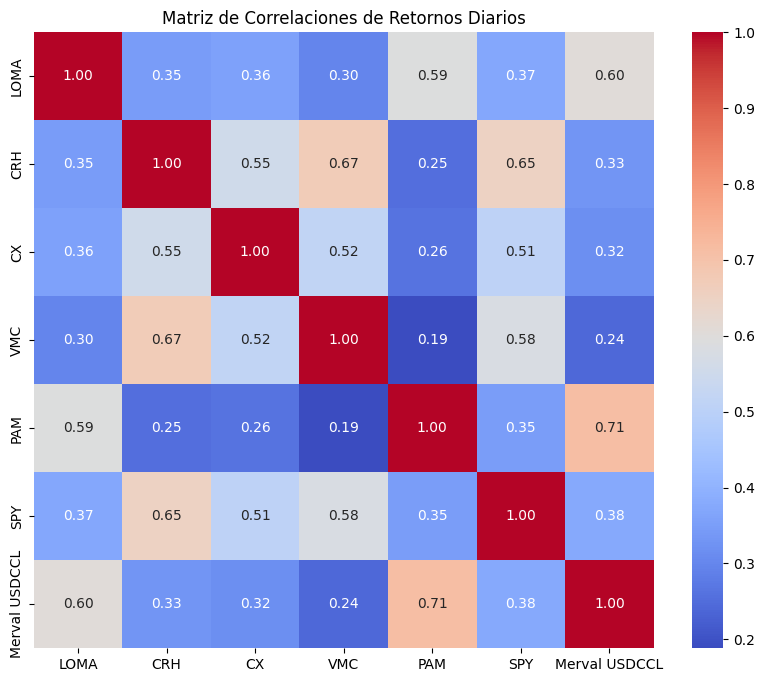


2. y 3. Análisis temporal de correlaciones (Crisis vs. Normales) y Efecto Contagio...

Correlación durante período de Crisis (2020-03-01 a 2020-04-30):
No hay datos disponibles para el período de crisis especificado.
Rango de fechas disponible en los retornos: 2020-07-02 00:00:00 a 2025-08-15 00:00:00

Correlación durante período Normal (2021-01-01 a 2021-12-31):


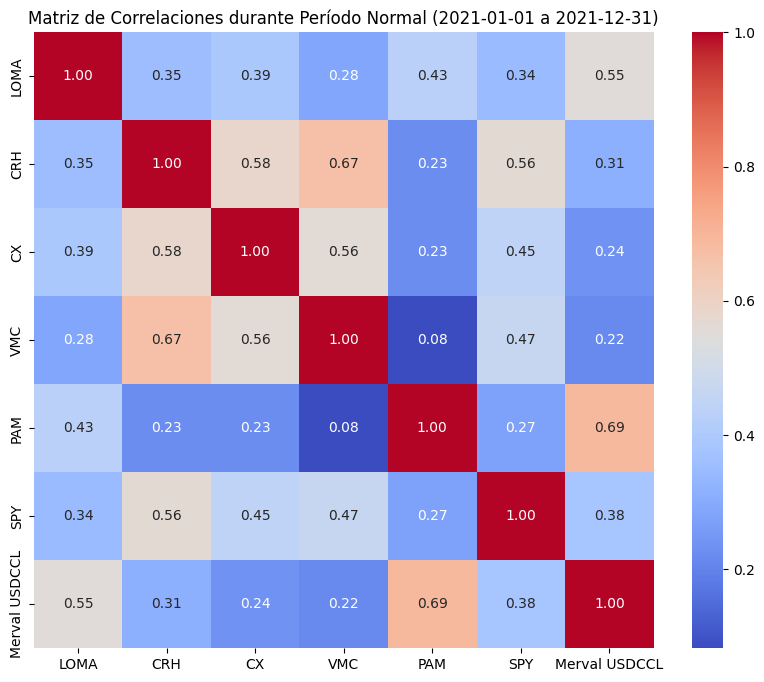

                   LOMA       CRH        CX       VMC       PAM       SPY  \
LOMA           1.000000  0.351527  0.393041  0.283426  0.430442  0.344230   
CRH            0.351527  1.000000  0.582885  0.669481  0.225185  0.564007   
CX             0.393041  0.582885  1.000000  0.559180  0.225045  0.446297   
VMC            0.283426  0.669481  0.559180  1.000000  0.082160  0.466359   
PAM            0.430442  0.225185  0.225045  0.082160  1.000000  0.274324   
SPY            0.344230  0.564007  0.446297  0.466359  0.274324  1.000000   
Merval USDCCL  0.551956  0.310575  0.238960  0.216453  0.689331  0.380021   

               Merval USDCCL  
LOMA                0.551956  
CRH                 0.310575  
CX                  0.238960  
VMC                 0.216453  
PAM                 0.689331  
SPY                 0.380021  
Merval USDCCL       1.000000  

Análisis del Efecto Contagio: Comparar las matrices de correlación de crisis y normal.
Observar si las correlaciones tienden a aumenta

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarse de que df_analysis esté disponible y tenga los datos correctos
if 'df_analysis' not in locals():
    print("Error: DataFrame df_analysis no encontrado. Por favor, ejecute las celdas anteriores para crearlo.")
else:
    # Calcular retornos diarios para el análisis de correlación
    returns = df_analysis.pct_change().dropna()

    # 1. Matriz de correlaciones con visualización
    print("1. Generando matriz de correlaciones...")
    correlation_matrix = returns.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Matriz de Correlaciones de Retornos Diarios')
    plt.show()

    # 2. Análisis temporal: Correlaciones en períodos de crisis vs. normales.
    # 3. Efecto contagio: ¿Aumentan las correlaciones en crisis?.
    print("\n2. y 3. Análisis temporal de correlaciones (Crisis vs. Normales) y Efecto Contagio...")

    # Definir períodos (estos son ejemplos y deben ajustarse según eventos de mercado reales)
    crisis_start = '2020-03-01'
    crisis_end = '2020-04-30'

    # Ejemplo Período Normal: Un período relativamente estable
    normal_start = '2021-01-01'
    normal_end = '2021-12-31'

    # Filtrar datos para los períodos (asegurarse de que las fechas estén dentro del rango de df_analysis)
    crisis_returns = returns.loc[crisis_start:crisis_end].dropna()
    normal_returns = returns.loc[normal_start:normal_end].dropna()

    print(f"\nCorrelación durante período de Crisis ({crisis_start} a {crisis_end}):")
    if not crisis_returns.empty:
        crisis_correlation_matrix = crisis_returns.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(crisis_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f'Matriz de Correlaciones durante Crisis ({crisis_start} a {crisis_end})')
        plt.show()
        print(crisis_correlation_matrix)
    else:
        print("No hay datos disponibles para el período de crisis especificado.")
        print(f"Rango de fechas disponible en los retornos: {returns.index.min()} a {returns.index.max()}")


    print(f"\nCorrelación durante período Normal ({normal_start} a {normal_end}):")
    if not normal_returns.empty:
        normal_correlation_matrix = normal_returns.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(normal_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f'Matriz de Correlaciones durante Período Normal ({normal_start} a {normal_end})')
        plt.show()
        print(normal_correlation_matrix)
    else:
         print("No hay datos disponibles para el período normal especificado.")
         print(f"Rango de fechas disponible en los retornos: {returns.index.min()} a {returns.index.max()}")


    print("\nAnálisis del Efecto Contagio: Comparar las matrices de correlación de crisis y normal.")
    print("Observar si las correlaciones tienden a aumentar durante el período de crisis.")

    # 4. Implicancias para diversificación
    print("\n4. Implicancias para la Diversificación:")
    print("Una menor correlación entre activos generalmente reduce el riesgo del portafolio.")
    print("Los activos con baja o negativa correlación son valiosos para la diversificación.")
    print("Analizar las correlaciones, especialmente durante las crisis, ayuda a entender la efectividad de la diversificación en diferentes escenarios de mercado.")
    print("Las correlaciones más altas en períodos de crisis (efecto contagio) pueden reducir los beneficios de la diversificación justo cuando más se necesita.")

###Pregunta Crítica
¿Por qué ciertas acciones están más correlacionadas que otras y cómo afecta esto tu estrategia de diversificación?

Entender las correlaciones es fundamental para armar un portafolio resistente. Para un inversor argentino, la inclusión de activos internacionales está justificada para mitigar el riesgo local, mientras que las altas correlaciones entre activos nacionales subrayan la importancia de diversificar fuera del país para una protección efectiva ante shocks locales.

---
##4. Optimización de Portfolio

* Simulación de 2000+ portfolios aleatorios
* Restricciones realistas:
  * Máximo 40% en un solo activo.
  * Mínimo 5% en cada activo seleccionado.
  * Costos de transacción 0.5%.
* Cálculo de portfolios específicos:
  * Máximo Sharpe Ratio.
  * Mínimo riesgo.
  * Tu elección personal.
* Frontera eficiente graficada.

---

###Simulacion de portafolios

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Asegurarse de que el DataFrame df_analysis esté disponible y contenga los datos correctos
if 'df_analysis' not in locals():
    print("Error: DataFrame df_analysis no encontrado. Por favor, ejecute la celda de carga de datos primero.")
else:
    # --- 1. Optimización General (Máximo Sharpe Ratio y Mínimo Riesgo) ---

    # Usar solo las columnas de los activos para la optimización general
    assets = ['LOMA', 'CRH', 'CX', 'VMC', 'PAM'] # Las 5 empresas
    df_assets = df_analysis[assets].copy()

    # Calcular los retornos diarios
    returns = df_assets.pct_change().dropna()

    # Calcular los retornos diarios promedio anualizados
    # Asumiendo 252 días de trading en un año
    avg_returns_annual = returns.mean() * 252

    # Calcular la matriz de covarianza anualizada
    cov_matrix_annual = returns.cov() * 252

    # Definir el número de portafolios a simular
    num_portfolios = 10000  # Número de simulaciones solicitado

    # Definir la tasa libre de riesgo (ejemplo: usando un valor bajo)
    risk_free_rate = 0.02 # Ejemplo: tasa libre de riesgo anualizada del 2%

    # Definir los costos de transacción (como porcentaje)
    transaction_cost_rate = 0.005 # 0.5% de costo de transacción

    # Almacenar resultados de las simulaciones
    results = np.zeros((4, num_portfolios)) # 3 métricas + 1 para retorno ajustado por costos
    weights_record = []

    # Definir restricciones
    max_weight_per_asset = 0.40 # Máximo 40% en un solo activo
    min_weight_per_asset = 0.05 # Mínimo 5% en cada activo seleccionado

    print(f"Simulando {num_portfolios} portafolios aleatorios con restricciones...")

    valid_portfolios_count = 0
    for i in range(num_portfolios):
        # Generar pesos aleatorios que suman 1
        weights = np.random.random(len(assets))
        weights /= np.sum(weights)

        # Verificar restricciones
        if (np.max(weights) > max_weight_per_asset) or (np.min(weights) < min_weight_per_asset):
             continue # Saltar este portafolio si no cumple las restricciones

        # Calcular retorno anual del portafolio (antes de costos de transacción)
        portfolio_return = np.sum(weights * avg_returns_annual)

        # Calcular volatilidad anual del portafolio
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual, weights)))

        # Calcular costo de transacción (simplificado)
        transaction_cost = np.sum(np.abs(weights)) * transaction_cost_rate # Costo basado en valor total operado (suma de pesos es 1) * tasa

        # Ajustar retorno por costos de transacción
        adjusted_portfolio_return = portfolio_return - transaction_cost

        # Calcular Ratio de Sharpe (usando retorno ajustado)
        sharpe_ratio = (adjusted_portfolio_return - risk_free_rate) / portfolio_volatility

        # Almacenar resultados para portafolios válidos
        results[0, valid_portfolios_count] = portfolio_volatility
        results[1, valid_portfolios_count] = adjusted_portfolio_return # Almacenar retorno ajustado
        results[2, valid_portfolios_count] = sharpe_ratio
        results[3, valid_portfolios_count] = portfolio_return # Almacenar retorno original para comparación
        weights_record.append(weights)
        valid_portfolios_count += 1

    # Recortar los resultados y weights_record para incluir solo portafolios válidos
    results = results[:, :valid_portfolios_count]
    weights_record = weights_record[:valid_portfolios_count]


    # Verificar si se encontraron portafolios válidos en la simulación general
    if valid_portfolios_count == 0:
        print("\nNo se encontraron portafolios válidos que cumplan las restricciones en la simulación general.")
        print("No se podrán calcular los portafolios generales ni la frontera eficiente.")
        # Establecer banderas o variables a None para indicar fallo
        max_sharpe_portfolio_volatility = None
        min_volatility_portfolio_volatility = None
        efficient_frontier_volatility = []
        efficient_frontier_return = []
        max_sharpe_portfolio_return = None
        min_volatility_portfolio_return = None
        max_sharpe_weights = [np.nan] * len(assets)
        min_volatility_weights = [np.nan] * len(assets)

    else:
        # Encontrar el portafolio con el Máximo Ratio de Sharpe
        max_sharpe_idx = np.argmax(results[2])
        max_sharpe_portfolio_volatility = results[0, max_sharpe_idx]
        max_sharpe_portfolio_return = results[1, max_sharpe_idx]
        max_sharpe_weights = weights_record[max_sharpe_idx]

        # Encontrar el portafolio con el Mínimo Riesgo (volatilidad)
        min_volatility_idx = np.argmin(results[0])
        min_volatility_portfolio_volatility = results[0, min_volatility_idx]
        min_volatility_portfolio_return = results[1, min_volatility_idx]
        min_volatility_weights = weights_record[min_volatility_idx]

        # --- Calcular la Frontera Eficiente ---
        # Necesitamos encontrar los portafolios óptimos para un rango de retornos objetivo
        # Definir un rango de retornos objetivo desde el retorno del portafolio de mínima volatilidad hasta el retorno máximo simulado
        target_returns = np.linspace(min_volatility_portfolio_return, results[1, :].max(), 100)

        # Función a minimizar (volatilidad) para un retorno objetivo dado
        def portfolio_volatility_for_target_return(weights):
            return np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual, weights)))

        # Función de restricción para el retorno objetivo
        def return_constraint(weights, target_return):
            return np.sum(weights * avg_returns_annual) - target_return

        # Función de restricción para que la suma de los pesos sea 1
        def sum_weights_constraint(weights):
            return np.sum(weights) - 1

        # Límites para los pesos (min_weight_per_asset, max_weight_per_asset)
        bounds = tuple((min_weight_per_asset, max_weight_per_asset) for asset in assets)

        # Pesos iniciales (distribución equitativa)
        initial_weights = len(assets) * [1./len(assets),]

        efficient_frontier_volatility = []
        efficient_frontier_return = [] # Almacenar retorno original para graficar la frontera

        # Calcular los puntos de la frontera eficiente (volatilidad para cada retorno objetivo)
        if target_returns.size > 0:
            for target_return in target_returns:
                # Crear una lista de restricciones para cada optimización
                current_constraints = [{'type': 'eq', 'fun': sum_weights_constraint},
                                       {'type': 'eq', 'fun': lambda w: return_constraint(w, target_return)}]

                # Realizar la optimización
                result = minimize(portfolio_volatility_for_target_return, initial_weights, method='SLSQP', bounds=bounds, constraints=current_constraints)

                if result.success:
                    efficient_frontier_volatility.append(result.fun)
                    # Calcular y almacenar el retorno ajustado para el portafolio optimizado
                    opt_weights = result.x
                    opt_original_return = np.sum(opt_weights * avg_returns_annual)
                    opt_transaction_cost = np.sum(np.abs(opt_weights)) * transaction_cost_rate
                    opt_adjusted_return = opt_original_return - opt_transaction_cost
                    efficient_frontier_return.append(opt_adjusted_return)

Simulando 10000 portafolios aleatorios con restricciones...


Mi portafolio consta de 50% Argentina & 50% Internacional con el maximo sharpe ratio simulado


Tabla Comparativa de Métricas:


,Métrica,Máximo Sharpe Ratio ( ),Mínimo Riesgo ( ),Mi portafolio
0,Retorno Anualizado (Ajustado),0.3562,0.3060,0.3683
1,Volatilidad Anualizada,0.2762,0.2496,0.2917
2,Ratio de Sharpe,1.2175,1.1461,1.1941



Tabla Comparativa de Pesos:


,Activo,Máximo Sharpe Ratio ( ),Mínimo Riesgo ( ),Mi portafolio
0,LOMA,0.0552,0.0591,0.1000
1,CRH,0.3376,0.2634,0.2522
2,CX,0.0781,0.0885,0.1549
3,VMC,0.1525,0.3940,0.0928
4,PAM,0.3765,0.1950,0.4000



--- Gráfico de Portafolios y Frontera Eficiente ---


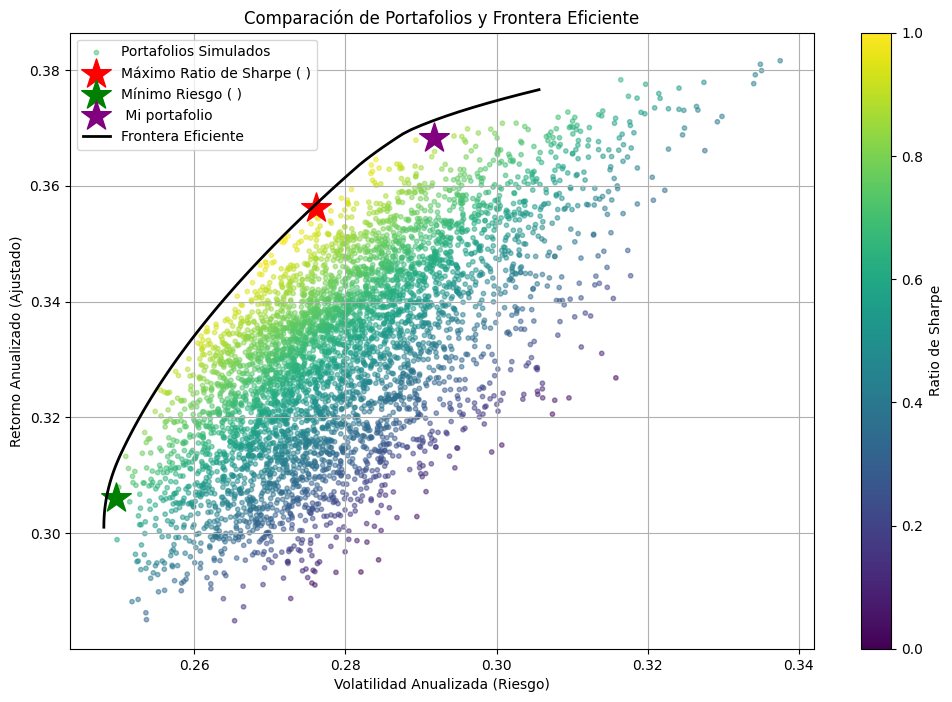

In [8]:
    # --- 2. Optimización para Portafolio con Restricción Específica (50% Argentina / 50% Internacional) ---

    # Definir las acciones argentinas e internacionales
    arg_assets = ['LOMA', 'PAM']
    int_assets = ['CRH', 'CX', 'VMC']
    # El orden de los activos DEBE coincidir con la segmentación para las restricciones de grupo
    assets_for_constrained_opt = arg_assets + int_assets # ['LOMA', 'PAM', 'CRH', 'CX', 'VMC']

    # Asegurarse de que las matrices de retornos y covarianza estén en el orden correcto para esta optimización
    # Usamos las matrices calculadas anteriormente (avg_returns_annual, cov_matrix_annual)
    # Asegurnos que están en el orden de assets_for_constrained_opt
    avg_returns_annual_ordered = avg_returns_annual[assets_for_constrained_opt]
    cov_matrix_annual_ordered = cov_matrix_annual.loc[assets_for_constrained_opt, assets_for_constrained_opt]


    # Función objetivo a minimizar (negativo del Ratio de Sharpe ajustado por costos) para esta optimización
    def negative_sharpe_ratio_constrained(weights):
        portfolio_return = np.sum(weights * avg_returns_annual_ordered)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual_ordered, weights)))
        transaction_cost = np.sum(np.abs(weights)) * transaction_cost_rate
        adjusted_portfolio_return = portfolio_return - transaction_cost
        if portfolio_volatility == 0:
            return 1e10 # Evitar división por cero
        return -(adjusted_portfolio_return - risk_free_rate) / portfolio_volatility

    # Definir las restricciones para la optimización restringida
    constraints_constrained = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, # Suma total = 1
        {'type': 'eq', 'fun': lambda weights: np.sum(weights[:len(arg_assets)]) - 0.5}, # Suma arg = 0.5
        {'type': 'eq', 'fun': lambda weights: np.sum(weights[len(arg_assets):]) - 0.5} # Suma int = 0.5
    ]

    # Límites para los pesos individuales (mínimo 0.05, máximo 0.40) - con el orden correcto de assets_for_constrained_opt
    bounds_constrained = tuple((min_weight_per_asset, max_weight_per_asset) for asset in assets_for_constrained_opt)

    # Pesos iniciales para la optimización CONSTRAINED (deben sumar 1 y cumplir 50/50 y bounds si es posible)
    # Un intento que cumple 50/50 y bounds: LOMA=0.25, PAM=0.25, CRH=0.1667, CX=0.1667, VMC=0.1667 (aproximado)
    # O una variación que cumple bounds: LOMA=0.2, PAM=0.3, CRH=0.2, CX=0.15, VMC=0.15
    initial_weights_constrained = np.array([0.2, 0.3, 0.2, 0.15, 0.15]) # LOMA, PAM, CRH, CX, VMC - Order matters!

    # Realizar la optimización para el portafolio restringido
    result_constrained = minimize(negative_sharpe_ratio_constrained, initial_weights_constrained, method='SLSQP', bounds=bounds_constrained, constraints=constraints_constrained)

    if result_constrained.success:
        max_sharpe_constrained_weights = result_constrained.x
        max_sharpe_constrained_return_orig = np.sum(max_sharpe_constrained_weights * avg_returns_annual_ordered)
        max_sharpe_constrained_volatility = np.sqrt(np.dot(max_sharpe_constrained_weights.T, np.dot(cov_matrix_annual_ordered, max_sharpe_constrained_weights)))
        max_sharpe_constrained_transaction_cost = np.sum(np.abs(max_sharpe_constrained_weights)) * transaction_cost_rate
        max_sharpe_constrained_return_adjusted = max_sharpe_constrained_return_orig - max_sharpe_constrained_transaction_cost
        max_sharpe_constrained_sharpe_ratio = (max_sharpe_constrained_return_adjusted - risk_free_rate) / max_sharpe_constrained_volatility

        # Eliminar la impresión directa de los resultados detallados del portafolio 50% Argentina / 50% Internacional
        # print("\nResultados del Portafolio 50% Argentina / 50% Internacional (Máximo Ratio de Sharpe):") # Translated
        # print(f"  Retorno Anualizado (Ajustado): {max_sharpe_constrained_return_adjusted:.4f}") # Translated
        # print(f"  Volatilidad Anualizada: {max_sharpe_constrained_volatility:.4f}") # Translated
        # print(f"  Ratio de Sharpe: {max_sharpe_constrained_sharpe_ratio:.4f}") # Translated
        # print("  Pesos (en orden LOMA, PAM, CRH, CX, VMC):") # Translated
        # for j, asset in enumerate(assets_for_constrained_opt):
        #     print(f"    {asset}: {max_sharpe_constrained_weights[j]:.4f}")

    else:
        print("\nLa optimización para el portafolio 50% Argentina / 50% Internacional no tuvo éxito.") # Translated
        print("Estado del resultado:", result_constrained.message) # Translated
        print("Esto puede ocurrir si las restricciones son incompatibles (ej. los límites individuales impiden cumplir la restricción 50/50).") # Translated
        # Set variables to None to indicate failure
        max_sharpe_constrained_volatility = None
        max_sharpe_constrained_return_adjusted = None
        max_sharpe_constrained_sharpe_ratio = None
        max_sharpe_constrained_weights = [np.nan] * len(assets_for_constrained_opt)


    # --- 3. Cuadro Comparativo de Portafolios ---

    # Asegurarse de que los pesos estén en el mismo orden para la tabla (usamos el orden 'assets')
    # Reindexar los pesos restringidos al orden de los activos generales para el cuadro si la optimización tuvo éxito
    if result_constrained.success:
         max_sharpe_constrained_weights_series = pd.Series(max_sharpe_constrained_weights, index=assets_for_constrained_opt)
         max_sharpe_constrained_weights_reindexed = max_sharpe_constrained_weights_series.reindex(assets).tolist()
    else:
         max_sharpe_constrained_weights_reindexed = [np.nan] * len(assets) # Usar NaN si la optimización falló


    # Asegurarse de que los pesos generales estén en el orden 'assets'
    max_sharpe_weights_series = pd.Series(max_sharpe_weights, index=assets)
    min_volatility_weights_series = pd.Series(min_volatility_weights, index=assets)


    # Crear DataFrame para las Métricas
    data_metrics = {
        'Métrica': ['Retorno Anualizado (Ajustado)', 'Volatilidad Anualizada', 'Ratio de Sharpe'],
        'Máximo Sharpe Ratio ( )': [
            f"{max_sharpe_portfolio_return:.4f}" if max_sharpe_portfolio_return is not None else "N/A",
            f"{max_sharpe_portfolio_volatility:.4f}" if max_sharpe_portfolio_volatility is not None else "N/A",
            f"{results[2, np.argmax(results[2])]:.4f}" if valid_portfolios_count > 0 else "N/A"
        ],
        'Mínimo Riesgo ( )': [
            f"{min_volatility_portfolio_return:.4f}" if min_volatility_portfolio_return is not None else "N/A",
            f"{min_volatility_portfolio_volatility:.4f}" if min_volatility_portfolio_volatility is not None else "N/A",
            f"{results[2, np.argmin(results[0])]:.4f}" if valid_portfolios_count > 0 else "N/A"
        ],
        '  Mi portafolio': [
            f"{max_sharpe_constrained_return_adjusted:.4f}" if max_sharpe_constrained_return_adjusted is not None else "N/A",
            f"{max_sharpe_constrained_volatility:.4f}" if max_sharpe_constrained_volatility is not None else "N/A",
            f"{max_sharpe_constrained_sharpe_ratio:.4f}" if max_sharpe_constrained_sharpe_ratio is not None else "N/A"
        ]
    }
    df_metrics = pd.DataFrame(data_metrics)
    print("\nTabla Comparativa de Métricas:")    # Removed 'title'
    display(df_metrics)

    # Crear DataFrame para los Pesos
    data_weights = {
        'Activo': assets,
        'Máximo Sharpe Ratio ( )': [f"{w:.4f}" if not np.isnan(w) else "N/A" for w in max_sharpe_weights_series],
        'Mínimo Riesgo ( )': [f"{w:.4f}" if not np.isnan(w) else "N/A" for w in min_volatility_weights_series],
        '  Mi portafolio': [f"{w:.4f}" if not np.isnan(w) else "N/A" for w in max_sharpe_constrained_weights_reindexed] # Usar pesos reindexados
    }
    df_weights = pd.DataFrame(data_weights)
    print("\nTabla Comparativa de Pesos:")    # Removed 'title'
    display(df_weights)


    # --- 4. Graficar los 3 Portafolios con la Frontera Eficiente ---
    print("\n--- Gráfico de Portafolios y Frontera Eficiente ---")

    plt.figure(figsize=(12, 8))

    # Gráfico de dispersión de todos los portafolios simulados (para contexto)
    if valid_portfolios_count > 0:
         plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.5, label='Portafolios Simulados') # Added label
    else:
         print("Advertencia: No hay portafolios simulados válidos para graficar.")


    # Graficar el portafolio de Máximo Ratio de Sharpe ( )
    if max_sharpe_portfolio_volatility is not None:
         plt.scatter(max_sharpe_portfolio_volatility, max_sharpe_portfolio_return, marker='*', color='red', s=500, label='Máximo Ratio de Sharpe ( )')

    # Graficar el portafolio de Mínimo Riesgo ( )
    if min_volatility_portfolio_volatility is not None:
        plt.scatter(min_volatility_portfolio_volatility, min_volatility_portfolio_return, marker='*', color='green', s=500, label='Mínimo Riesgo ( )')

    # Graficar el nuevo portafolio restringido
    if max_sharpe_constrained_volatility is not None:
        plt.scatter(max_sharpe_constrained_volatility, max_sharpe_constrained_return_adjusted, marker='*', color='purple', s=500, label=' Mi portafolio ')

    # Graficar la línea de la Frontera Eficiente
    if efficient_frontier_volatility and efficient_frontier_return:
         # Ordenar por volatilidad antes de graficar la línea
         frontier_points = sorted(zip(efficient_frontier_volatility, efficient_frontier_return))
         frontier_volatility_sorted, frontier_return_sorted = zip(*frontier_points)
         plt.plot(frontier_volatility_sorted, frontier_return_sorted, color='black', linestyle='-', linewidth=2, label='Frontera Eficiente')


    plt.title('Comparación de Portafolios y Frontera Eficiente')   # Removed 'title'
    plt.xlabel('Volatilidad Anualizada (Riesgo)')   # Removed 'xlabel'
    plt.ylabel('Retorno Anualizado (Ajustado)')   # Removed 'ylabel'
    if valid_portfolios_count > 0: # Solo mostrar colorbar si hay puntos simulados
         plt.colorbar(label='Ratio de Sharpe')   # Removed 'colorbar label'
    plt.grid(True)
    plt.legend()
    plt.show()

###Pregunta Crítica
Justificar tu elección de portfolio considerando tu perfil de riesgo personal, horizonte de inversión y expectativas macroeconómicas. ¿Por qué elegiste ese punto específico de la frontera eficiente?

Justificación de mi portafolio elegido **Máximo Sharpe con 50% Argentina & 50% Internacional**:

Seleccioné este portafolio porque, según mi perfil de riesgo, busco maximizar el retorno ajustado por riesgo (Ratio de Sharpe), pero también quiero mantener una diversificación geográfica equilibrada entre Argentina e internacionales. La distribución 50/50 permite aprovechar el potencial de recuperación o crecimiento de los activos argentinos, sin dejar de diversificar y reducir el riesgo a través de la exposición a mercados más estables y globales.

Elijo el punto de Máximo Sharpe dentro de la restricción 50/50 porque es el portafolio más eficiente posible bajo esa condición: logra el mejor equilibrio entre riesgo y retorno respetando mi preferencia de exposición a ambos mercados. Esta estrategia es adecuada para un horizonte de inversión de mediano/largo plazo, y refleja tanto un optimismo selectivo sobre Argentina como la necesidad de protección global frente al riesgo país.